In [6]:
import pandas as pd
import numpy as np
import scipy.stats as sc_stats
import matplotlib.pyplot as plt

In [7]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})


## Function declarations

### Read `ods` to `DataFrame`


In [8]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df


### Get accuracy measures

In [9]:
def get_accuracy_measures(dataframe):
  Y_t = dataframe["Y_t"]
  hat_Y_t = dataframe["hat_Y_t"]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

  

### Standard error of autocorrelation


In [10]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


### Compute `r_k`, `t_test`, and `LBQ`

In [11]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

### Plot of autocorrelation function

In [12]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


## Load the data

In [13]:
filename = "03-table-02-gasoline-purchase-spokane-transit.ods"
df = read_ods(filename, {"Week": "t", "Gallons": "Y_t"})
df.head()

,t,Y_t
0,1,275
1,2,291
2,3,307
3,4,281
4,5,295


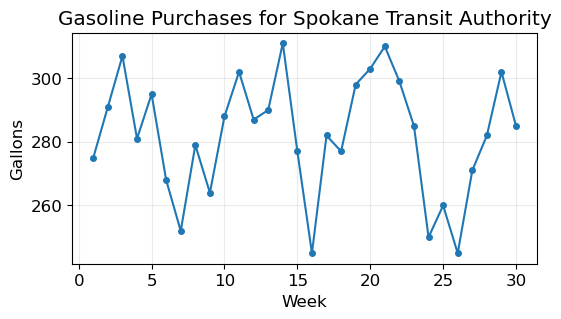

In [14]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Week")
ax.set_ylabel("Gallons")
ax.set_title("Gasoline Purchases for Spokane Transit Authority")
ax.grid("on")
plt.show(fig)


## Forecasting (simple average)

$$
  \hat{Y}_{t+1} = \frac{1}{t} \sum_{i=1}^{t} Y_i
$$

In [21]:
df_forecast = df.copy()
df_forecast["Y_tM1"] = df_forecast["Y_t"].shift(1)
df_forecast["hat_Y_t"] = df_forecast["Y_tM1"].expanding(min_periods=0).mean()
df_forecast["e_t"] = df_forecast["Y_t"] - df_forecast["hat_Y_t"]
df_forecast 


,t,Y_t,Y_tM1,hat_Y_t,e_t
0,1,275,NaN,NaN,NaN
1,2,291,275.0,275.000000,16.000000
2,3,307,291.0,283.000000,24.000000
3,4,281,307.0,291.000000,-10.000000
4,5,295,281.0,288.500000,6.500000
5,6,268,295.0,289.800000,-21.800000
6,7,252,268.0,286.166667,-34.166667
7,8,279,252.0,281.285714,-2.285714
8,9,264,279.0,281.000000,-17.000000
9,10,288,264.0,279.111111,8.888889


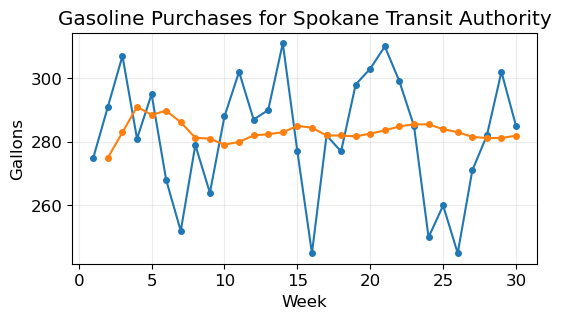

In [22]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast["t"], df_forecast["Y_t"], 
  marker='o', markersize=4)
ax.plot(df_forecast["t"], df_forecast["hat_Y_t"],
  marker='o', markersize=4)

ax.set_xlabel("Week")
ax.set_ylabel("Gallons")
ax.set_title("Gasoline Purchases for Spokane Transit Authority")
ax.grid("on")
plt.show(fig)


### residual

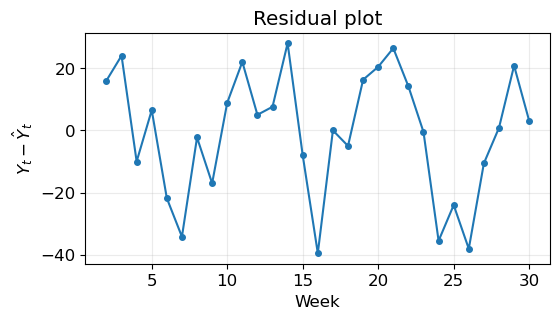

In [17]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast["t"], df_forecast["e_t"], 
  marker='o', markersize=4)

ax.set_xlabel("Week")
ax.set_ylabel("$Y_t - \hat{Y}_t$")
ax.set_title("Residual plot")
ax.grid("on")
plt.show(fig)


#### Accuracy measures

In [18]:
MAPE, MAD, MSD = get_accuracy_measures(df_forecast)
print(f"MAPE   {MAPE*100:8.3f}")
print(f"MAD    {MAD:8.3f}")
print(f"MSD    {MSD:8.3f}")

MAPE      5.837
MAD      16.076
MSD     393.179


#### Autocorrelation function for MA(5) residuals

In [19]:
num_of_rk = 6 
df_moveave = df_forecast.copy()
df_moveave = df_moveave.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_moveave, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.410111,2.208517,5.400142,-0.380380,0.380380
1,2,0.087516,0.407680,5.655159,-0.439727,0.439727
2,3,-0.187376,-0.867907,6.869149,-0.442240,0.442240
3,4,-0.547591,-2.472965,17.651986,-0.453581,0.453581
4,5,-0.553221,-2.095300,29.116222,-0.540840,0.540840
5,6,-0.218070,-0.723617,30.974984,-0.617311,0.617311


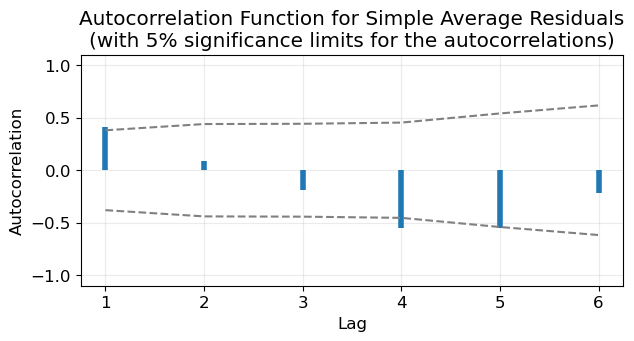

In [23]:
plot_autocorr_func(df_acorr_analysis, title="Simple Average Residuals")